# Final Project: Machine Learning Applications
## Bachelor in Data Science and Engineering

Done by:

* Alvaro Viejo Alonso (NIA: 100451677)
* Rodrigo Oliver Coimbra (NIA: 100451788)
* Héctor Tienda Cárdenas (NIA: 100)

## 0. Introduction and explanation

In this project we put in practice what was learned in the course of Machine Learning Applications on the area of Natural Language Processing (NLP). We will be analyzing a Goodreads book review dataset and we will be solving two learning tasks: regression (to predict the review score from the review text) and topic modelling (to predict the genre of the book that is being reviewed).

## 1. Data loading and preprocessing pipeline

### 1.1 Data loading

We are loading the `reviews_spoiler_reduced.csv` dataset which consists of three columns: `review_text` (string), `rating` (integer) and `book_genre` (factor).

In [8]:
# !conda install -c conda-forge spacy
# !conda install -c conda-forge cupy`
# !python -m spacy download en_core_web_trf

import spacy
import pandas as pd
import numpy as np
import csv 
import nltk
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from functools import partial
import sys
import multiprocessing as mp

# Create Pandas method to provide tqdm progress
tqdm.pandas()

In [2]:
# Load the sample dataset
sample_df = pd.read_csv("reviews_spoiler_reduced.csv", encoding="utf-8", index_col=0)

In [3]:
# Print the sample dataset
sample_df

,review_text,rating,book_genre
0,"I originally gave this three stars, but it was...",4,children
1,"they didnt actually quit, they just wrote lett...",4,children
2,This story follows a family consisting of a fa...,5,children
3,"I don't remember reading this book in school, ...",4,children
4,Read for the 2016 YA/MG Book Battle. This book...,5,children
...,...,...,...
443,Seriously dunno what to think.. This was my re...,3,young_adult
444,"Possible trigger warnings: abuse*, teen pregna...",5,young_adult
445,"I really loved this! ""To all the boys I've lov...",5,young_adult
446,"I wanted to give this book three stars, and I ...",4,young_adult


We load spaCy's `en_core_web_trf` model which is optimized for GPU (CUDA) usage and it is larger and slower but its provide more accuracy.

The spaCy library provides a trained model with several components that share the `tok2vec`component.



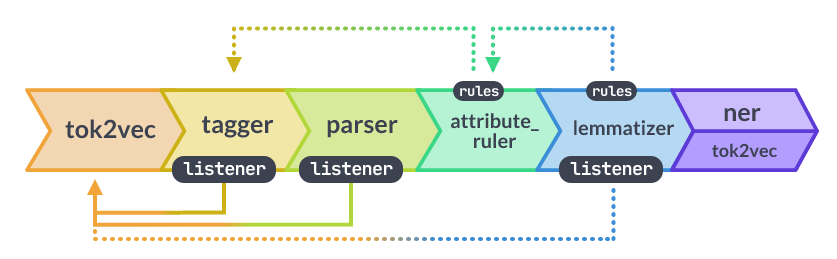

The first `tok2vec` attribute corresponds is this case tou our `transformer`, and it will be responsible for tokenizing the book reviews. 

Then we have the `tagger`which assings the POS (part-of-speech) tags to each word, followed by the `parser`that is tasked with assigning dependency labels. These are very important for spaCy's internal mechanisms and this analysis is further extended by `attribute_ruler` which contains specific rules for each language.

Finally we have the `lemmatizer` which draws from `attribute_ruler` to homogenize the text corpus by reducing the number of word variants (i.e. assigns base forms).

The `ner` (Named Entity Recognizer) is devoted to detecting and labelling named entities that have a specific meaning such as `Tencent` (corporation), `John` (person), `spaniards` (group of people) or `UN` (organization).

In [4]:
# Load the en_core_web_trf model
nlp = spacy.load("en_core_web_trf")

In [5]:
# Print spaCy's nlp pipe parts
print(nlp.pipe_names)

['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


### 1.2 Preprocessing

#### 1.2.1 Tokenization, homogenization, cleaning

In this subsection we will be performing tokenization, homegenization and cleaning using the SpaCy Python library. The `preprocess_text` function is that with the tokenization and lemmatization of all the book reviews and the removel of any stopwords (very common words), punctuation marks and whitespaces. All words are also converted to lowercase for uniformity.

SpaCy was used as it provides state-of-the-art tools in NLP and allows for a streamlined, yet powerful approach to data preprocessing.

In [6]:
def preprocess_text(text, model):
    """
    This function is tasked with tokenizing and lemmatizing the text while
    also removing stopwords, punctuation and whitespaces.
    It returns the remaining token as a string.
    """
    doc = model(text)
    tokens = [
                token.lemma_.lower().strip() \
                    for token in doc \
                        if token.is_alpha \
                        and not token.is_stop \
                        and not token.is_punct \
                        and not token.is_space
    ]
    return tokens

In [14]:
# Create a new column in the dataset to store the new, cleaned reviews
sample_df["doc"] = sample_df["review_text"].progress_apply(preprocess_text, model=nlp)

  0%|          | 0/448 [00:00<?, ?it/s]

In [28]:
import os
os.system('notify-send "Ejecución terminada" "Ya ha terminado de ejecutarse la celda"')


(notify-send:344351): libnotify-WARNING **: 17:15:25.037: Running in confined mode, using Portal notifications. Some features and hints won't be supported
libnotify-Message: 17:15:25.037: Category is not available when using Portal Notifications
libnotify-Message: 17:15:25.037: App Name is not available when using Portal Notifications


0

In [29]:
# Print the transformed Pandas dataframe
sample_df

,review_text,rating,book_genre,doc
0,"I originally gave this three stars, but it was...",4,children,"[originally, give, star, close, decide, miserl..."
1,"they didnt actually quit, they just wrote lett...",4,children,"[nt, actually, quit, write, letter, complaint,..."
2,This story follows a family consisting of a fa...,5,children,"[story, follow, family, consist, father, mothe..."
3,"I don't remember reading this book in school, ...",4,children,"[remember, read, book, school, decide, try, lo..."
4,Read for the 2016 YA/MG Book Battle. This book...,5,children,"[read, ya, mg, book, battle, book, simply, cha..."
...,...,...,...,...
443,Seriously dunno what to think.. This was my re...,3,young_adult,"[seriously, dunno, think, reaction, novel, con..."
444,"Possible trigger warnings: abuse*, teen pregna...",5,young_adult,"[possible, trigger, warning, abuse, teen, preg..."
445,"I really loved this! ""To all the boys I've lov...",5,young_adult,"[love, boy, love, unique, diverse, novel, wond..."
446,"I wanted to give this book three stars, and I ...",4,young_adult,"[want, book, star, think, half, quarter, book,..."


## 2. Text vectorization

In the text vectorization part we will be analyzing the following vectorization schemes:

- Bag-of-Words vs. TF-IDF representation
- Word2vec/FastText vs. Doc2Vec
- Theme extraction and vector representation using LDA.

In this part we will be using Gensim.

### 2.1 Gensim Corpus and N-grams detection

#### 2.1.1 Gensim Corpus

In [30]:
sample_corpus = sample_df["doc"].tolist()

print(sample_corpus)
# To avoid errors with Phraser
#sample_corpus = [str(el) for el in sample_corpus]

[['originally', 'give', 'star', 'close', 'decide', 'miserly', 'bump', 'kid', 'kid', 'mean', 'young', 'middling', 'teenager', 'maybe', 'advanced', 'pre', 'teen', 'like', 'read', 'scary', 'story', 'outer', 'limits', 'twilight', 'zone', 'kind', 'feel', 'apparently', 'mean', 'middle', 'grade', 'book', 'storytelling', 'style', 'like', 'element', 'bit', 'gruesome', 'thing', 'particular', 'detail', 'end', 'spoiler', 'tag', 'scare', 'point', 'threshold', 'scare', 'thing', 'kind', 'low', 'scared', 'see', 'blair', 'witch', 'project', 'assure', 'total', 'wimp', 'scare', 'thematically', 'friendship', 'conform', 'ideal', 'normalcy', 'perfection', 'temptation', 'try', 'change', 'people', 'feel', 'like', 'story', 'element', 'manipulate', 'maximum', 'deftness', 'handle', 'reasonably', 'like', 'visual', 'design', 'book', 'endpaper', 'pattern', 'creepy', 'bug', 'text', 'drawing', 'small', 'bug', 'appear', 'margin', 'thing', 'gross', 'see', 'come', 'wince', 'confirm', 'ew', 'soylent', 'green', 'people', 

In [31]:
print(f"Number of documents in corpus: {len(sample_corpus)}")
print(f"First review text: \n {sample_corpus[0]}")

Number of documents in corpus: 448
First review text: 
 ['originally', 'give', 'star', 'close', 'decide', 'miserly', 'bump', 'kid', 'kid', 'mean', 'young', 'middling', 'teenager', 'maybe', 'advanced', 'pre', 'teen', 'like', 'read', 'scary', 'story', 'outer', 'limits', 'twilight', 'zone', 'kind', 'feel', 'apparently', 'mean', 'middle', 'grade', 'book', 'storytelling', 'style', 'like', 'element', 'bit', 'gruesome', 'thing', 'particular', 'detail', 'end', 'spoiler', 'tag', 'scare', 'point', 'threshold', 'scare', 'thing', 'kind', 'low', 'scared', 'see', 'blair', 'witch', 'project', 'assure', 'total', 'wimp', 'scare', 'thematically', 'friendship', 'conform', 'ideal', 'normalcy', 'perfection', 'temptation', 'try', 'change', 'people', 'feel', 'like', 'story', 'element', 'manipulate', 'maximum', 'deftness', 'handle', 'reasonably', 'like', 'visual', 'design', 'book', 'endpaper', 'pattern', 'creepy', 'bug', 'text', 'drawing', 'small', 'bug', 'appear', 'margin', 'thing', 'gross', 'see', 'come', '

<Axes: ylabel='Count'>

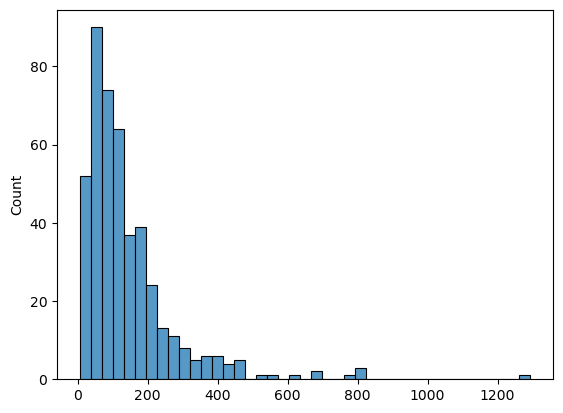

In [32]:
sns.histplot(data=sample_corpus, x=[len(doc) for doc in sample_corpus])

#### 2.1.2 N-grams

In [33]:
phrase_model = gensim.models.phrases.Phrases(sample_corpus, min_count=2, threshold=30)
sample_corpus = [el for el in phrase_model[sample_corpus]]

sample_df["doc"] = sample_corpus